# HypergraphKHopLifting Tutorial

In [11]:
# With this cell any imported module is reloaded before each cell execution
%load_ext autoreload
%autoreload 2

In [1]:
import rootutils
import json

rootutils.setup_root("./", indicator=".project-root", pythonpath=True)
root_folder = rootutils.find_root()
import omegaconf
from modules.io.load.loaders import GraphLoader

# Load Dataset Config

Either we keep yaml config files and provide a brief overview of them, or we build the required config files by hand in these tutorials. (I prefer the former option.)

In [2]:
dataset_name = "manual_dataset"
dataset_config = omegaconf.OmegaConf.load(
    f"{root_folder}/configs/dataset/{dataset_name}.yaml"
).parameters

#### Print dataset config

In [3]:
# Print config file for nice visualization
dict2print = dataset_config.copy()
print(json.dumps(dict(dict2print), indent=4))

{
    "data_domain": "graph",
    "data_type": "manual_dataset",
    "data_name": "manual",
    "data_dir": "/challenge-icml-2024/datasets/graph/manual_dataset",
    "num_features": 1,
    "num_classes": 2,
    "task": "classification",
    "loss_type": "cross_entropy",
    "monitor_metric": "accuracy",
    "task_level": "node",
    "split_type": "k-fold",
    "k": 10,
    "data_seed": 0
}


# Load Transform Config file

Same dilemma as before, yaml files or dicts within tutorials.

In [4]:
# Define lifting type
lifting_type = "graph2hypergraph"

# Define lifting id (name)
id_lifting = "khop_lifting"

# Read yaml file
transform_config = {
    "lifting": omegaconf.OmegaConf.load(
        f"{root_folder}/configs/transforms/liftings/{lifting_type}/{id_lifting}.yaml"
    )
    # other transforms (e.g. data manipulations, feature liftings) can be added here
}

### Print transform config

In [5]:
# Print config file for nice visualization
dict2print = transform_config.copy()
dict2print["lifting"] = dict(dict2print["lifting"])

print(json.dumps(dict(dict2print), sort_keys=True, indent=4))

{
    "lifting": {
        "_target_": "modules.transforms.data_transform.DataTransform",
        "feature_lifting": "SumLifting",
        "k_value": 1,
        "transform_name": "HypergraphKHopLifting",
        "transform_type": "lifting"
    }
}


### Load Dataset

In [6]:
dataset = GraphLoader(dataset_config, transform_config).load()

Transform parameters are the same, using existing data_dir: /challenge-icml-2024/datasets/graph/manual_dataset/manual/lifting/3568131876


/usr/local/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:301: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [7]:
transform_config['lifting']['k_value']=1
dataset = GraphLoader(dataset_config, transform_config).load()

Transform parameters are the same, using existing data_dir: /challenge-icml-2024/datasets/graph/manual_dataset/manual/lifting/3568131876


In [8]:
dataset['incidence_hyperedges'].shape

torch.Size([8, 8])

### Visualize graph

In [9]:
print(dataset)

Data(x=[8, 1], edge_index=[2, 13], y=[8], num_nodes=8, incidence_hyperedges=[8, 8], num_hyperedges=8, x_0=[8, 1], x_hyperedges=[8, 1])


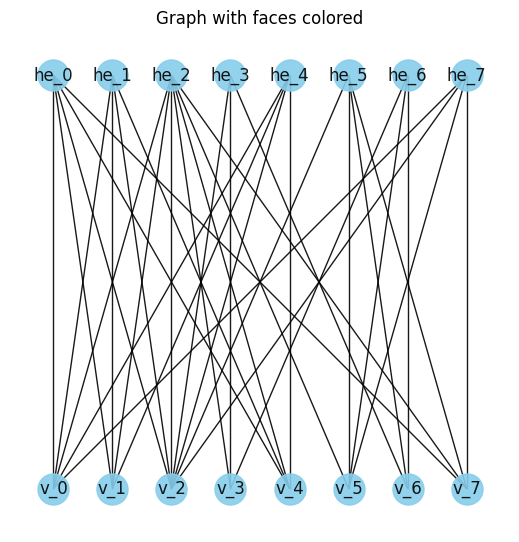

In [39]:
from modules.io.utils.utils import plot_manual_graph
plot_manual_graph(dataset)
# DONE FOR SIMPLICIAL COMPLEXES; Shall we do smth similar with cells and hypergraphs?

### Create a Neural Network Model

In [ ]:
from topomodelx.nn.hypergraph.unigcn import UniGCN
import torch


class Network(torch.nn.Module):
    def __init__(
        self,
        in_channels,
        hidden_channels,
        out_channels,
    ):
        super().__init__()
        self.base_model = UniGCN(
            in_channels,
            hidden_channels,
        )
        self.linear_0 = torch.nn.Linear(hidden_channels, out_channels)
        self.linear_1 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, data):
        x_0, x_1 = self.base_model(
            data.x_0,
            data.incidence_hyperedges,
        )
        x_0 = self.linear_0(x_0)
        x_1 = self.linear_1(x_1)
        return x_0, x_1

### Run the Model

In [ ]:
in_channels = dataset_config["num_features"]
hidden_channels = 32
out_channels = dataset_config["num_classes"]

model = Network(
    in_channels=in_channels,
    hidden_channels=hidden_channels,
    out_channels=out_channels,
)

In [ ]:
y_hat = model(dataset)

In [ ]:
dataset

Data(x=[8, 1], edge_index=[2, 13], y=[8], num_nodes=8, incidence_hyperedges=[8, 8], num_hyperedges=8, x_0=[8, 1], x_hyperedges=[8, 1])

Note that for simplicity and visualization reason we utilised simple graph, however there is a set of available datasets that you can play with.

In [ ]:
dataset_names = [
    # Working datasets:
    # "cocitation_cora",
    # "cocitation_citeseer",
    # "cocitation_pubmed",
    # "MUTAG",
    # "NCI1",
    # "NCI109",
    # Something is wrong with the following datasets:
    # "IMDB-BINARY",
    # "IMDB-MULTI",
    # "REDDIT-BINARY",
]
for dataset_name in dataset_names:
    dataset_config = omegaconf.OmegaConf.load(
        f"{root_folder}/configs/dataset/{dataset_name}.yaml"
    ).parameters

    dataset = GraphLoader(dataset_config, transform_config).load()

# Define lifting type
# lifting_type = "graph2simplicial"

# # Define lifting id (name)
# id_lifting = "simplicial_clique"

# # Read yaml file
# transform_config = {
#     "lifting": omegaconf.OmegaConf.load(
#         f"{root_folder}/configs/transforms/topological_liftings/{lifting_type}/{id_lifting}.yaml"
#     )
#     # other transforms (e.g. data manipulations, feature liftings) can be added here
# }

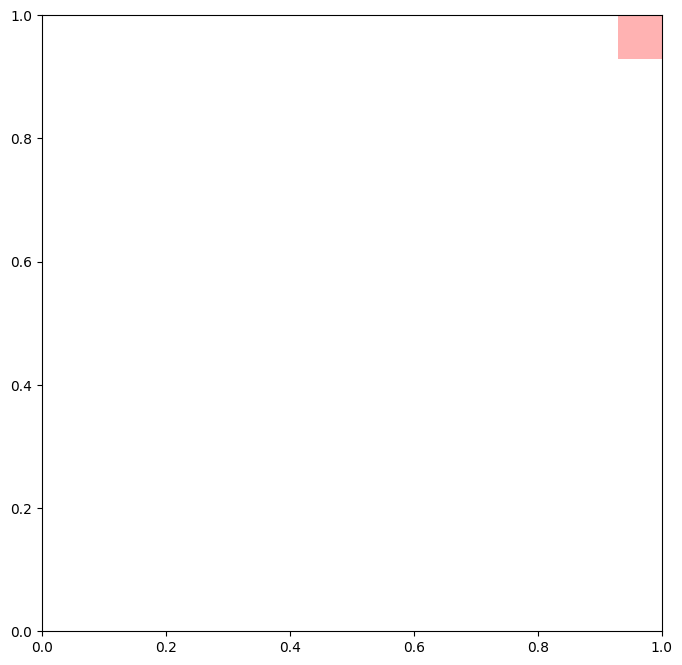

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon

def draw_polygon_with_min_distance(vertices):
    # Compute the convex hull of the vertices
    def sort_vertices_ccw(vertices):
        # Function to sort the vertices of a polygon to fill it correctly
        centroid = [sum(v[0] for v in vertices) / len(vertices),
                    sum(v[1] for v in vertices) / len(vertices)]
        return sorted(vertices, key=lambda v: (np.arctan2(v[1] - centroid[1], v[0] - centroid[0])))

    hull_vertices = np.array(sort_vertices_ccw(vertices))

    # Calculate the centroid of the convex hull
    centroid = np.mean(hull_vertices, axis=0)

    # Calculate vectors from centroid to vertices
    vectors = hull_vertices - centroid

    # Normalize vectors and scale by min_distance
    min_distance = np.min(abs(centroid-hull_vertices))
    normalized_vectors = vectors / np.linalg.norm(vectors, axis=1)[:, np.newaxis] * min_distance * 0.2
    # Create offset vertices
    offset_vertices = hull_vertices + normalized_vectors
    
    poly = Polygon(offset_vertices,
                   closed=True,
                   fill=True,
                   facecolor='r',# edgecolor="pink",
                   alpha=0.3,
            )
    plt.gca().add_patch(poly)

    # Show the plot
    plt.show()

# Example vertices
vertices = [(1, 2), (2, 1), (2, 2), (1, 1)]

# Minimum distance
min_distance = 1

# Draw polygon with minimum distance
draw_polygon_with_min_distance(vertices)
